In [99]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [100]:
import numpy as np
import tensorflow as tf
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import datetime
import json

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from keras.initializers import Constant
from keras.optimizers import SGD, Adam
from keras.layers import TextVectorization
from keras import Model
from keras.src.optimizers.legacy.adadelta import Adadelta
from keras.callbacks import ModelCheckpoint

from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.decomposition import PCA
from sklearn.model_selection import ParameterGrid, StratifiedKFold

In [101]:
sns.set_style('darkgrid')

# Reading the data

In [102]:
def read_corpus(corpus_file):
    '''Read in review data set and returns docs and labels'''
    documents = []
    labels = []
    with open(corpus_file, encoding='utf-8') as f:
        for line in f:
            tokens = line.strip()
            documents.append(" ".join(tokens.split()[3:]).strip())
            # 6-class problem: books, camera, dvd, health, music, software
            labels.append(tokens.split()[0])
    return documents, labels

In [103]:
def read_embeddings(embeddings_file):
    '''Read in word embeddings from file and save as numpy array'''
    embeddings = json.load(open(embeddings_file, 'r'))
    return {word: np.array(embeddings[word]) for word in embeddings}

In [104]:
X_train, y_train = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_3/train.txt')
X_val, y_val = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_3/dev.txt')
X_test, y_test = read_corpus('/content/gdrive/MyDrive/University/learning_from_data/assignment_3/test.txt')

In [105]:
embeddings = read_embeddings('/content/gdrive/MyDrive/University/learning_from_data/assignment_3/glove_reviews.json')

# Preprocessing

## Create embedding matrix

In [106]:
def get_emb_matrix(voc, emb):
    '''Get embedding matrix given vocab and the embeddings'''
    num_tokens = len(voc) + 2
    word_index = dict(zip(voc, range(len(voc))))
    # Bit hacky, get embedding dimension from the word "the"
    embedding_dim = len(emb["the"])
    # Prepare embedding matrix to the correct size
    embedding_matrix = np.zeros((num_tokens, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = emb.get(word)
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
    # Final matrix with pretrained embeddings that we can feed to embedding layer
    return embedding_matrix


In [107]:
vectorizer = TextVectorization(standardize=None, output_sequence_length=50)
# Use train and dev to create vocab - could also do just train
text_ds = tf.data.Dataset.from_tensor_slices(X_train + X_val)
vectorizer.adapt(text_ds)

In [108]:
# Dictionary mapping words to idx
voc = vectorizer.get_vocabulary()
emb_matrix = get_emb_matrix(voc, embeddings)

## Binarize labels and vectorize words

In [109]:
# Transform string labels to one-hot encodings
encoder = LabelBinarizer()
y_train_bin = encoder.fit_transform(y_train)  # Use encoder.classes_ to find mapping back
y_val_bin = encoder.fit_transform(y_val)

In [110]:
# Transform input to vectorized input
X_train_vect = vectorizer(np.array([[s] for s in X_train])).numpy()
X_val_vect = vectorizer(np.array([[s] for s in X_val])).numpy()

# Training

## Set-up: Create and train model functions

In [111]:
def evaluate(model, X_test, Y_test, ident):
    '''Do predictions and measure accuracy on our own test set (that we split off train)'''
    # Get predictions using the trained model
    Y_pred = model.predict(X_test)
    # Finally, convert to numerical labels to get scores with sklearn
    Y_pred = np.argmax(Y_pred, axis=1)
    # If you have gold data, you can calculate accuracy
    Y_test = np.argmax(Y_test, axis=1)
    print('Accuracy on own {1} set: {0}'.format(round(accuracy_score(Y_test, Y_pred), 3), ident))
    return accuracy_score(Y_test, Y_pred)

In [112]:
def create_model_adaptive(y_train, emb_matrix, learning_rate, loss_function, optimizer, layers, activation):
  """
  This method is a more generic version of the supplied create_model
  function.

  layers: This should contain a number of keras layers which are added to the
  model in sequence. This way, this function can generate models with different
  architectures.
  """

  # Take embedding dim and size from emb_matrix
  embedding_dim = len(emb_matrix[0])
  num_tokens = len(emb_matrix)
  num_labels = len(set(y_train))

  # We pass the class to the grid search and then instantiate here so that the
  # optimizer variables are freshly initialized each time
  optimizer_initialized = optimizer()

  # Set the learning rate here to make the grid search more elegant
  optimizer_initialized.learning_rate.assign(learning_rate)

  model = Sequential()
  model.add(Embedding(num_tokens, embedding_dim, embeddings_initializer=Constant(emb_matrix),trainable=False))

  for layer in layers:
    model.add(layer)

  model.add(Dense(input_dim=embedding_dim, units=num_labels, activation=activation))
  model.compile(loss=loss_function, optimizer=optimizer_initialized, metrics=['accuracy'])
  return model

In [113]:
def train_model_adaptive(model, X_train, y_train, X_val, y_val, epochs, batch_size):
  """
  This method is a more generic version of the supplied train_model function.
  """
  verbose = 1
  # Early stopping: stop training when there are three consecutive epochs without improving
  # It's also possible to monitor the training loss with monitor="loss"
  callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  model.fit(X_train, y_train, verbose=verbose, epochs=epochs, callbacks=[callback], batch_size=batch_size, validation_data=(X_val, y_val))
  return model

## Exploration: t-SNE embedding

In [116]:
def plot_2d_tsne(X, y):
  tsne = TSNE(n_components=2, init='random', perplexity=30, n_iter=250, random_state=0)
  X_tsne = tsne.fit_transform(X)
  X_tsne_df = pd.DataFrame.from_records(X_tsne, columns=['X_1', 'X_2'])
  X_tsne_df['y'] = y_train
  standard_scaler = StandardScaler()
  X_tsne_df['X_1'], X_tsne_df['X_2'] = standard_scaler.fit_transform(np.array([X_tsne_df['X_1'], X_tsne_df['X_2']]).T).T
  return X_tsne_df

In [117]:
initial_lstm_layers = [
    LSTM(64, return_sequences=True),
    LSTM(64, return_sequences=True),
    LSTM(64),
]

initial_lstm_model = create_model_adaptive(
  y_train=y_train,
  emb_matrix=emb_matrix,
  learning_rate=0.0005,
  loss_function='squared_hinge',
  activation='softmax',
  optimizer=Adam,
  layers=initial_lstm_layers,
)

initial_lstm_model = train_model_adaptive(
  model=initial_lstm_model,
  X_train=X_train_vect,
  y_train=y_train_bin,
  X_val=X_val_vect,
  y_val=y_val_bin,
  epochs=50,
  batch_size=256,
)

Epoch 1/50
16/16 [==============================] - 7s 91ms/step - loss: 1.2431 - accuracy: 0.3150 - val_loss: 1.2229 - val_accuracy: 0.4080
Epoch 2/50
16/16 [==============================] - 0s 15ms/step - loss: 1.1861 - accuracy: 0.4735 - val_loss: 1.1494 - val_accuracy: 0.5490
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 1.0688 - accuracy: 0.7265 - val_loss: 1.0147 - val_accuracy: 0.7610
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.9803 - accuracy: 0.7955 - val_loss: 0.9974 - val_accuracy: 0.7590
Epoch 5/50
16/16 [==============================] - 0s 17ms/step - loss: 0.9696 - accuracy: 0.7962 - val_loss: 0.9690 - val_accuracy: 0.8000
Epoch 6/50
16/16 [==============================] - 0s 21ms/step - loss: 0.9438 - accuracy: 0.8380 - val_loss: 0.9452 - val_accuracy: 0.8400
Epoch 7/50
16/16 [==============================] - 0s 22ms/step - loss: 0.9362 - accuracy: 0.8497 - val_loss: 0.9423 - val_accuracy: 0.8400
Epoch 8/50
16

In [118]:
extractor = Model(inputs=initial_lstm_model.inputs,
                        outputs=[layer.output for layer in initial_lstm_model.layers])
features = extractor(X_train_vect)

In [119]:
input = features[0]
lstm_output_1 = np.take(features[1], -1, axis=1) # Take last element her since sequences are returned
lstm_output_2 = np.take(features[2], -1, axis=1) # Take last element her since sequences are returned
lstm_output_3 = features[3]

intermediate_outputs = [
    (np.max(input, axis=1), 'Embeddings (max)'),
    (lstm_output_1, 'LSTM output (layer 1)'),
    (lstm_output_2, 'LSTM output (layer 2)'),
    (lstm_output_3, 'LSTM output (layer 3)'),
]

plot_df = pd.DataFrame({})

for X, name in intermediate_outputs:
  X_tsne_df = plot_2d_tsne(X, y_train)
  X_tsne_df['name'] = name
  plot_df = pd.concat([plot_df, X_tsne_df])

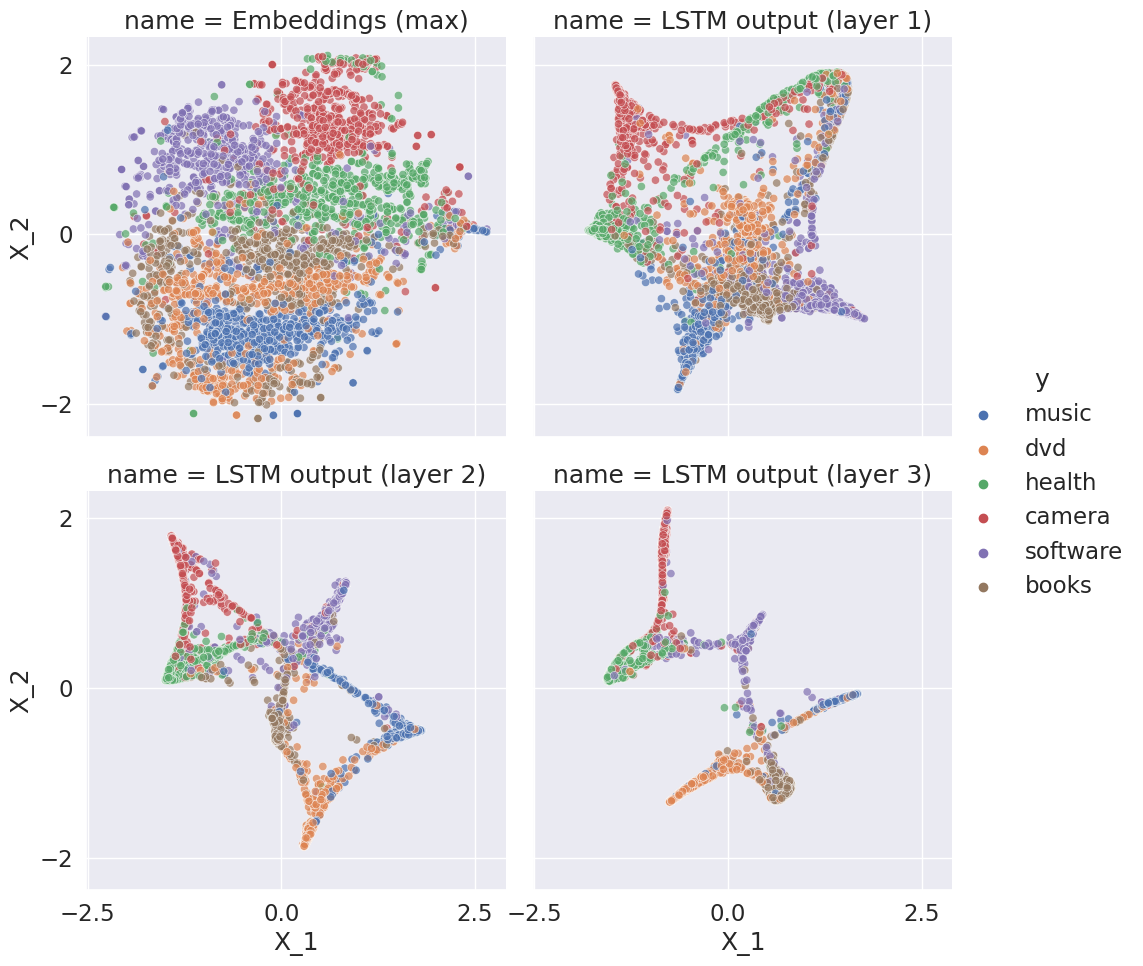

In [121]:
sns.relplot(data=plot_df, x='X_1', y='X_2', hue='y', col='name', alpha=0.7, col_wrap=2)
sns.set(font_scale=5)

plt.savefig(f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/plots/manifold_{datetime.datetime.now().isoformat()}.svg')

## Exploration: Basic LSTM Architectures

### Definitions

In [31]:
def set_up_lstm_layers(params):
  layers = []
  for i in range(1, params['n_layers']):
    layers.append(LSTM(params['neurons_per_layer'], return_sequences=True))
  layers.append(LSTM(params['neurons_per_layer']))
  return layers

In [32]:
def run_grid_search(grid_search_params, emb_matrix, X_train_vect, y_train_bin, X_val_vect, y_val_bin, y_train, results_path, n_iterations):
  results = []

  for params in grid_search_params:
    accuracies_on_split = []
    for _ in range(0, n_iterations):
      # This is a bit cryptic maybe, but it allows me to easily re-use this grid
      # search function with multiple architectures
      layers = params['set_up_function'](params)

      # Create model
      model = create_model_adaptive(
        y_train=y_train,
        emb_matrix=emb_matrix,
        learning_rate=params['learning_rate'],
        loss_function=params['loss_function'],
        optimizer=params['optimizer'],
        activation=params['activation'],
        layers=layers
      )
      # Train the model
      model = train_model_adaptive(
        model=model,
        X_train=X_train_vect,
        y_train=y_train_bin,
        X_val=X_val_vect,
        y_val=y_val_bin,
        epochs=params['epochs'],
        batch_size=params['batch_size'],
      )

      accuracies_on_split.append(evaluate(model, X_val_vect, y_val_bin, "validation"))
    results_with_params = params
    results_with_params['accuracy'] = np.mean(accuracies_on_split)
    results.append(results_with_params)

  results_df = pd.DataFrame.from_records(results)
  results_df.to_csv(results_path)

In [33]:
def generate_grid_search_params_architecture():
  param_grid = {
    'learning_rate': [0.0005],
    'activation': ['softmax'],
    'loss_function': ['squared_hinge'],
    'optimizer': [Adam],
    'batch_size': [256],
    'epochs': [50],
    # The parameters below are specific for this architecture search
    'neurons_per_layer': [32, 64, 128, 256],
    'n_layers': range(1, 5),
    'set_up_function': [set_up_lstm_layers]
  }
  return ParameterGrid(param_grid)

### Grid search

In [34]:
architecture_grid_search_results_path = f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/results/architecture_grid_search/results_df_2.csv'

In [37]:
grid_search_params = generate_grid_search_params_architecture()
run_grid_search(
    grid_search_params,
    emb_matrix,
    X_train_vect,
    y_train_bin,
    X_val_vect,
    y_val_bin,
    y_train,
    architecture_grid_search_results_path,
    5
)

Epoch 1/50
16/16 [==============================] - 5s 66ms/step - loss: 1.2490 - accuracy: 0.1930 - val_loss: 1.2456 - val_accuracy: 0.2390
Epoch 2/50
16/16 [==============================] - 0s 16ms/step - loss: 1.2408 - accuracy: 0.3338 - val_loss: 1.2352 - val_accuracy: 0.3690
Epoch 3/50
16/16 [==============================] - 0s 17ms/step - loss: 1.2235 - accuracy: 0.4613 - val_loss: 1.2059 - val_accuracy: 0.4840
Epoch 4/50
16/16 [==============================] - 0s 11ms/step - loss: 1.1843 - accuracy: 0.5215 - val_loss: 1.1566 - val_accuracy: 0.6120
Epoch 5/50
16/16 [==============================] - 0s 10ms/step - loss: 1.1271 - accuracy: 0.6515 - val_loss: 1.0965 - val_accuracy: 0.7270
Epoch 6/50
16/16 [==============================] - 0s 11ms/step - loss: 1.0704 - accuracy: 0.7602 - val_loss: 1.0522 - val_accuracy: 0.7740
Epoch 7/50
16/16 [==============================] - 0s 13ms/step - loss: 1.0296 - accuracy: 0.8005 - val_loss: 1.0206 - val_accuracy: 0.8070
Epoch 8/50
16

Grid search accuracy are mean of results over 5 training runs to compensate for the variance between training runs

In [171]:
results_df = pd.read_csv(architecture_grid_search_results_path, index_col=0)
results_df

,activation,batch_size,epochs,learning_rate,loss_function,n_layers,neurons_per_layer,optimizer,set_up_function,accuracy
0,softmax,256,50,0.0005,squared_hinge,1,32,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8688
1,softmax,256,50,0.0005,squared_hinge,1,64,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8764
2,softmax,256,50,0.0005,squared_hinge,1,128,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8716
3,softmax,256,50,0.0005,squared_hinge,1,256,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8590
4,softmax,256,50,0.0005,squared_hinge,2,32,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8596
5,softmax,256,50,0.0005,squared_hinge,2,64,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8542
6,softmax,256,50,0.0005,squared_hinge,2,128,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8624
7,softmax,256,50,0.0005,squared_hinge,2,256,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8362
8,softmax,256,50,0.0005,squared_hinge,3,32,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8412
9,softmax,256,50,0.0005,squared_hinge,3,64,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_lstm_layers at 0x7fb82d8b5900>,0.8584


In [172]:
results_df.loc[results_df['accuracy'].idxmax()]

activation                                                   softmax
batch_size                                                       256
epochs                                                            50
learning_rate                                                 0.0005
loss_function                                          squared_hinge
n_layers                                                           1
neurons_per_layer                                                 64
optimizer                   <class 'keras.src.optimizers.adam.Adam'>
set_up_function      <function set_up_lstm_layers at 0x7fb82d8b5900>
accuracy                                                      0.8764
Name: 1, dtype: object

In [173]:
results_df.groupby('n_layers').mean()

<ipython-input-173-8519d6e335b1>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby('n_layers').mean()


,batch_size,epochs,learning_rate,neurons_per_layer,accuracy
n_layers,,,,,
1,256.0,50.0,0.0005,120.0,0.86895
2,256.0,50.0,0.0005,120.0,0.85310
3,256.0,50.0,0.0005,120.0,0.85050
4,256.0,50.0,0.0005,120.0,0.83940


In [174]:
results_df.groupby('neurons_per_layer').mean()

<ipython-input-174-23b5e98aa1be>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  results_df.groupby('neurons_per_layer').mean()


,batch_size,epochs,learning_rate,n_layers,accuracy
neurons_per_layer,,,,,
32,256.0,50.0,0.0005,2.5,0.85055
64,256.0,50.0,0.0005,2.5,0.86050
128,256.0,50.0,0.0005,2.5,0.85520
256,256.0,50.0,0.0005,2.5,0.84570


Main takeaway here is that a relatively low amount of layers performs best. Might be valuable still to try a higher amount of layers but with dropout to see if the higher layer networks are limited by overfitting considerably.

## Exploration: Dropout layers

The following architectures could be generated using loops, but it will become quite a confusing loop structure for the reader, and defining the architectures in separate functions also allows us to re-use single architectures from later in the code.

In [35]:
def set_up_candidate_one(params):
  layers = []
  layers.append(LSTM(256, return_sequences=True))
  layers.append(LSTM(256))
  return layers

In [36]:
def set_up_candidate_one_with_one_dropout(params):
  layers = []
  layers.append(LSTM(256, return_sequences=True))
  layers.append(Dropout(0.5))
  layers.append(LSTM(256))
  return layers

In [37]:
def set_up_candidate_one_with_two_dropout(params):
  layers = []
  layers.append(LSTM(256, return_sequences=True))
  layers.append(Dropout(0.5))
  layers.append(LSTM(256))
  layers.append(Dropout(0.5))
  return layers

In [38]:
def set_up_candidate_two(params):
  layers = []
  layers.append(LSTM(64))
  return layers

In [39]:
def set_up_candidate_two_with_dropout(params):
  layers = []
  layers.append(LSTM(64))
  layers.append(Dropout(0.5))
  return layers

In [40]:
def generate_grid_search_params_dropout():
  param_grid = {
    'learning_rate': [0.0005],
    'activation': ['softmax'],
    'loss_function': ['squared_hinge'],
    'optimizer': [Adam],
    'batch_size': [256],
    'epochs': [50],
    'set_up_function': [set_up_candidate_one, set_up_candidate_one_with_one_dropout, set_up_candidate_one_with_two_dropout, set_up_candidate_two, set_up_candidate_two_with_dropout]
  }
  return ParameterGrid(param_grid)

In [43]:
dropout_results_path = f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/results/architecture_grid_search/dropout_results.csv'

In [ ]:


grid_search_params_dropout = generate_grid_search_params_dropout()
run_grid_search(
    grid_search_params_dropout,
    emb_matrix,
    X_train_vect,
    y_train_bin,
    X_val_vect,
    y_val_bin,
    y_train,
    dropout_results_path,
    5
)

In [44]:
dropout_results = pd.read_csv(dropout_results_path, index_col=0)
dropout_results

,activation,batch_size,epochs,learning_rate,loss_function,optimizer,set_up_function,accuracy
0,softmax,256,50,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_one at 0x7fb82a93b520>,0.8568
1,softmax,256,50,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_one_with_one_dropou...,0.8650
2,softmax,256,50,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_one_with_two_dropou...,0.8680
3,softmax,256,50,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7fb82a93bb50>,0.8648
4,softmax,256,50,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two_with_dropout at...,0.8648


Decision: Drop candidate one without dropout, and drop candidate two with dropout since performance is very similar

## Exploration: Hyperparameters

In [45]:
def generate_grid_search_params_hyperparameters():
  param_grid = {
    'learning_rate': [0.0001, 0.0005, 0.001],
    'activation': ['softmax', 'sigmoid', 'tanh', 'relu'],
    'loss_function': ['squared_hinge', 'categorical_crossentropy'],
    'optimizer': [Adam],
    'batch_size': [256],
    'epochs': [50],
    'set_up_function': [set_up_candidate_one_with_two_dropout, set_up_candidate_two]
  }
  return ParameterGrid(param_grid)

In [46]:
hyperparameters_results_path = f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/results/architecture_grid_search/hyperparameters_results.csv'

In [169]:
grid_search_params_hyperparameters = generate_grid_search_params_hyperparameters()
run_grid_search(
    grid_search_params_hyperparameters,
    emb_matrix,
    X_train_vect,
    y_train_bin,
    X_val_vect,
    y_val_bin,
    y_train,
    hyperparameters_results_path,
    1
)

Epoch 1/50
16/16 [==============================] - 39s 2s/step - loss: 1.2481 - accuracy: 0.1972 - val_loss: 1.2439 - val_accuracy: 0.3140
Epoch 2/50
16/16 [==============================] - 1s 41ms/step - loss: 1.2388 - accuracy: 0.3192 - val_loss: 1.2295 - val_accuracy: 0.4230
Epoch 3/50
16/16 [==============================] - 1s 40ms/step - loss: 1.2021 - accuracy: 0.4608 - val_loss: 1.1625 - val_accuracy: 0.5460
Epoch 4/50
16/16 [==============================] - 1s 42ms/step - loss: 1.1311 - accuracy: 0.5345 - val_loss: 1.0765 - val_accuracy: 0.6980
Epoch 5/50
16/16 [==============================] - 1s 39ms/step - loss: 1.0331 - accuracy: 0.7352 - val_loss: 0.9865 - val_accuracy: 0.7910
Epoch 6/50
16/16 [==============================] - 1s 39ms/step - loss: 0.9702 - accuracy: 0.8035 - val_loss: 0.9720 - val_accuracy: 0.7920
Epoch 7/50
16/16 [==============================] - 1s 38ms/step - loss: 0.9507 - accuracy: 0.8255 - val_loss: 0.9507 - val_accuracy: 0.8240
Epoch 8/50
16/

In [47]:
hyperparameters_results = pd.read_csv(hyperparameters_results_path, index_col=0)
hyperparameters_results

,activation,batch_size,epochs,learning_rate,loss_function,optimizer,set_up_function,accuracy
0,softmax,256,50,0.0001,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_one_with_two_dropou...,0.840
1,softmax,256,50,0.0001,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7fb82a93bb50>,0.837
2,softmax,256,50,0.0001,categorical_crossentropy,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_one_with_two_dropou...,0.881
3,softmax,256,50,0.0001,categorical_crossentropy,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7fb82a93bb50>,0.861
4,softmax,256,50,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_one_with_two_dropou...,0.863
5,softmax,256,50,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7fb82a93bb50>,0.873
6,softmax,256,50,0.0005,categorical_crossentropy,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_one_with_two_dropou...,0.894
7,softmax,256,50,0.0005,categorical_crossentropy,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7fb82a93bb50>,0.881
8,softmax,256,50,0.0010,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_one_with_two_dropou...,0.683
9,softmax,256,50,0.0010,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7fb82a93bb50>,0.877


In [48]:
hyperparameters_results.loc[hyperparameters_results['accuracy'].idxmax()]

activation                                                   softmax
batch_size                                                       256
epochs                                                            50
learning_rate                                                 0.0005
loss_function                               categorical_crossentropy
optimizer                   <class 'keras.src.optimizers.adam.Adam'>
set_up_function    <function set_up_candidate_one_with_two_dropou...
accuracy                                                       0.894
Name: 6, dtype: object

In [49]:
hyperparameters_results.groupby('set_up_function').mean()

<ipython-input-49-95cae9403848>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hyperparameters_results.groupby('set_up_function').mean()


,batch_size,epochs,learning_rate,accuracy
set_up_function,,,,
<function set_up_candidate_one_with_two_dropout at 0x7fb82a938b80>,256.0,50.0,0.000533,0.509375
<function set_up_candidate_two at 0x7fb82a93bb50>,256.0,50.0,0.000533,0.588167


Decision: Drop candidate one

In [51]:
hyperparameters_results.groupby('learning_rate').mean()

<ipython-input-51-976c738366e7>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hyperparameters_results.groupby('learning_rate').mean()


,batch_size,epochs,accuracy
learning_rate,,,
0.0001,256.0,50.0,0.520500
0.0005,256.0,50.0,0.583812
0.0010,256.0,50.0,0.542000


Decision: Keep 0.0005 as learning rate

In [52]:
hyperparameters_results.groupby('loss_function').mean()

<ipython-input-52-3f37e7c99d4b>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hyperparameters_results.groupby('loss_function').mean()


,batch_size,epochs,learning_rate,accuracy
loss_function,,,,
categorical_crossentropy,256.0,50.0,0.000533,0.533083
squared_hinge,256.0,50.0,0.000533,0.564458


Decision: Keep both

In [53]:
hyperparameters_results.groupby('activation').mean()

<ipython-input-53-8e3ae61b1b4a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hyperparameters_results.groupby('activation').mean()


,batch_size,epochs,learning_rate,accuracy
activation,,,,
relu,256.0,50.0,0.000533,0.302833
sigmoid,256.0,50.0,0.000533,0.519583
softmax,256.0,50.0,0.000533,0.855333
tanh,256.0,50.0,0.000533,0.517333


Keep softmax as activation

In [58]:
def generate_grid_search_params_hyperparameters_iteration_two():
  param_grid = {
    'learning_rate': [0.0005],
    'activation': ['softmax'],
    'loss_function': ['categorical_crossentropy', 'kl_divergence', 'mse', 'squared_hinge'],
    'optimizer': [Adam],
    'batch_size': [64, 128, 256],
    'epochs': [50, 100, 200],
    'set_up_function': [set_up_candidate_two]
  }
  return ParameterGrid(param_grid)

In [59]:
hyperparameters_iteration_two_results_path = f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/results/architecture_grid_search/hyperparameters_iteration_two_results.csv'

In [60]:
grid_search_params_hyperparameters_iteration_two = generate_grid_search_params_hyperparameters_iteration_two()
run_grid_search(
    grid_search_params_hyperparameters_iteration_two,
    emb_matrix,
    X_train_vect,
    y_train_bin,
    X_val_vect,
    y_val_bin,
    y_train,
    hyperparameters_iteration_two_results_path,
    1
)

Epoch 1/50
63/63 [==============================] - 3s 14ms/step - loss: 1.5834 - accuracy: 0.3760 - val_loss: 1.1268 - val_accuracy: 0.5950
Epoch 2/50
63/63 [==============================] - 0s 6ms/step - loss: 0.8866 - accuracy: 0.7017 - val_loss: 0.8171 - val_accuracy: 0.7380
Epoch 3/50
63/63 [==============================] - 0s 6ms/step - loss: 0.5699 - accuracy: 0.8238 - val_loss: 0.5380 - val_accuracy: 0.8440
Epoch 4/50
63/63 [==============================] - 0s 7ms/step - loss: 0.4562 - accuracy: 0.8627 - val_loss: 0.4654 - val_accuracy: 0.8590
Epoch 5/50
63/63 [==============================] - 0s 6ms/step - loss: 0.3704 - accuracy: 0.8855 - val_loss: 0.4217 - val_accuracy: 0.8760
Epoch 6/50
63/63 [==============================] - 0s 6ms/step - loss: 0.3200 - accuracy: 0.9043 - val_loss: 0.4052 - val_accuracy: 0.8740
Epoch 7/50
63/63 [==============================] - 0s 6ms/step - loss: 0.2973 - accuracy: 0.9105 - val_loss: 0.3933 - val_accuracy: 0.8800
Epoch 8/50
63/63 [=

In [61]:
hyperparameters_iteration_two_results = pd.read_csv(hyperparameters_iteration_two_results_path, index_col=0)
hyperparameters_iteration_two_results

,activation,batch_size,epochs,learning_rate,loss_function,optimizer,set_up_function,accuracy
0,softmax,64,50,0.0005,categorical_crossentropy,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.878
1,softmax,64,50,0.0005,kl_divergence,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.883
2,softmax,64,50,0.0005,mse,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.879
3,softmax,64,50,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.884
4,softmax,64,100,0.0005,categorical_crossentropy,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.892
5,softmax,64,100,0.0005,kl_divergence,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.894
6,softmax,64,100,0.0005,mse,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.897
7,softmax,64,100,0.0005,squared_hinge,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.885
8,softmax,64,200,0.0005,categorical_crossentropy,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.892
9,softmax,64,200,0.0005,kl_divergence,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.902


In [62]:
best_params = hyperparameters_iteration_two_results.loc[hyperparameters_iteration_two_results['accuracy'].idxmax()]
best_params

activation                                                   softmax
batch_size                                                        64
epochs                                                           200
learning_rate                                                 0.0005
loss_function                                          kl_divergence
optimizer                   <class 'keras.src.optimizers.adam.Adam'>
set_up_function    <function set_up_candidate_two at 0x7f31cb673c70>
accuracy                                                       0.902
Name: 9, dtype: object

Both of the other optimizers are very slow to converge so we drop them

In [64]:
hyperparameters_iteration_two_results.groupby('epochs').mean()

<ipython-input-64-42d7a0420162>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hyperparameters_iteration_two_results.groupby('epochs').mean()


,batch_size,learning_rate,accuracy
epochs,,,
50,149.333333,0.0005,0.879583
100,149.333333,0.0005,0.884083
200,149.333333,0.0005,0.881000


In [66]:
hyperparameters_iteration_two_results.groupby('loss_function').mean()

<ipython-input-66-234310c03adc>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hyperparameters_iteration_two_results.groupby('loss_function').mean()


,batch_size,epochs,learning_rate,accuracy
loss_function,,,,
categorical_crossentropy,149.333333,116.666667,0.0005,0.882778
kl_divergence,149.333333,116.666667,0.0005,0.886444
mse,149.333333,116.666667,0.0005,0.881000
squared_hinge,149.333333,116.666667,0.0005,0.876000


Kullback leibler divergence seems best

In [67]:
hyperparameters_iteration_two_results.groupby('batch_size').mean()

<ipython-input-67-48abbfa4c2d8>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hyperparameters_iteration_two_results.groupby('batch_size').mean()


,epochs,learning_rate,accuracy
batch_size,,,
64,116.666667,0.0005,0.886500
128,116.666667,0.0005,0.882083
256,116.666667,0.0005,0.876083


Try out lower batch sizes in next grid search

### Iteration three: Final

In [73]:
def generate_grid_search_params_hyperparameters_iteration_three():
  param_grid = {
    'learning_rate': [0.0005],
    'activation': ['softmax'],
    'loss_function': ['kl_divergence'],
    'optimizer': [Adam],
    'batch_size': [8, 16, 32, 64],
    'epochs': [200],
    'set_up_function': [set_up_candidate_two]
  }
  return ParameterGrid(param_grid)

In [74]:
hyperparameters_iteration_three_results_path = f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/results/architecture_grid_search/hyperparameters_iteration_three_results.csv'

In [75]:
grid_search_params_hyperparameters_iteration_three = generate_grid_search_params_hyperparameters_iteration_three()
run_grid_search(
    grid_search_params_hyperparameters_iteration_three,
    emb_matrix,
    X_train_vect,
    y_train_bin,
    X_val_vect,
    y_val_bin,
    y_train,
    hyperparameters_iteration_three_results_path,
    1
)

Epoch 1/200
500/500 [==============================] - 5s 6ms/step - loss: 1.0490 - accuracy: 0.6115 - val_loss: 0.5778 - val_accuracy: 0.8270
Epoch 2/200
500/500 [==============================] - 3s 6ms/step - loss: 0.4816 - accuracy: 0.8462 - val_loss: 0.4986 - val_accuracy: 0.8510
Epoch 3/200
500/500 [==============================] - 3s 6ms/step - loss: 0.3822 - accuracy: 0.8795 - val_loss: 0.3801 - val_accuracy: 0.8860
Epoch 4/200
500/500 [==============================] - 3s 7ms/step - loss: 0.3178 - accuracy: 0.9050 - val_loss: 0.4490 - val_accuracy: 0.8640
Epoch 5/200
500/500 [==============================] - 3s 5ms/step - loss: 0.2783 - accuracy: 0.9115 - val_loss: 0.3765 - val_accuracy: 0.8900
Epoch 6/200
500/500 [==============================] - 3s 5ms/step - loss: 0.2269 - accuracy: 0.9308 - val_loss: 0.3681 - val_accuracy: 0.8950
Epoch 7/200
500/500 [==============================] - 3s 5ms/step - loss: 0.2096 - accuracy: 0.9383 - val_loss: 0.3481 - val_accuracy: 0.9030

In [76]:
hyperparameters_iteration_three_results = pd.read_csv(hyperparameters_iteration_three_results_path, index_col=0)
hyperparameters_iteration_three_results

,activation,batch_size,epochs,learning_rate,loss_function,optimizer,set_up_function,accuracy
0,softmax,8,200,0.0005,kl_divergence,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.890
1,softmax,16,200,0.0005,kl_divergence,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.883
2,softmax,32,200,0.0005,kl_divergence,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.892
3,softmax,64,200,0.0005,kl_divergence,<class 'keras.src.optimizers.adam.Adam'>,<function set_up_candidate_two at 0x7f31cb673c70>,0.881


In [88]:
def train_model_adaptive_keep_best(model, X_train, y_train, X_val, y_val, epochs, batch_size, model_number):
  """
  This method is a more generic version of the supplied train_model function.
  We remove early stopping here to squeeze a bit more performance out of the
  final model.
  """
  verbose = 1
  # Early stopping: stop training when there are three consecutive epochs without improving
  # It's also possible to monitor the training loss with monitor="loss"
  callback = ModelCheckpoint(f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/results/final_models/{model_number}.weights', monitor='val_loss', mode='min', save_best_only=True, save_weights_only=True)
  model.fit(X_train, y_train, verbose=verbose, epochs=epochs, callbacks=[callback], batch_size=batch_size, validation_data=(X_val, y_val))
  return model

In [98]:
for i in range(0, 5):
  current_max_performance = 0
  best_model = None

  final_model_i = create_model_adaptive(
    y_train=y_train,
    emb_matrix=emb_matrix,
    learning_rate=0.0005,
    loss_function='kl_divergence',
    activation='softmax',
    optimizer=Adam,
    layers=set_up_candidate_two(None),
  )

  final_model_i = train_model_adaptive_keep_best(
    model=final_model_i,
    X_train=X_train_vect,
    y_train=y_train_bin,
    X_val=X_val_vect,
    y_val=y_val_bin,
    epochs=50,
    batch_size=8,
    model_number=i
  )

  final_model_i.load_weights(f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/results/final_models/{i}.weights')

  performance = evaluate(final_model_i, X_val_vect, y_val_bin, "validation")
  if performance > current_max_performance:
    best_model = i
    current_max_performance = performance

Epoch 1/50
500/500 [==============================] - 7s 9ms/step - loss: 1.0114 - accuracy: 0.6270 - val_loss: 0.5717 - val_accuracy: 0.8230
Epoch 2/50
500/500 [==============================] - 3s 6ms/step - loss: 0.4813 - accuracy: 0.8497 - val_loss: 0.4132 - val_accuracy: 0.8820
Epoch 3/50
500/500 [==============================] - 3s 6ms/step - loss: 0.3931 - accuracy: 0.8755 - val_loss: 0.3649 - val_accuracy: 0.8960
Epoch 4/50
500/500 [==============================] - 4s 7ms/step - loss: 0.3028 - accuracy: 0.9072 - val_loss: 0.3657 - val_accuracy: 0.8950
Epoch 5/50
500/500 [==============================] - 3s 7ms/step - loss: 0.2696 - accuracy: 0.9187 - val_loss: 0.3842 - val_accuracy: 0.8830
Epoch 6/50
500/500 [==============================] - 3s 6ms/step - loss: 0.2290 - accuracy: 0.9325 - val_loss: 0.3548 - val_accuracy: 0.8900
Epoch 7/50
500/500 [==============================] - 3s 5ms/step - loss: 0.2136 - accuracy: 0.9327 - val_loss: 0.4085 - val_accuracy: 0.8700
Epoch 

In [114]:
final_model = create_model_adaptive(
    y_train=y_train,
    emb_matrix=emb_matrix,
    learning_rate=0.0005,
    loss_function='kl_divergence',
    activation='softmax',
    optimizer=Adam,
    layers=set_up_candidate_two(None),
  )

# final_model = 4
final_model.load_weights(f'/content/gdrive/MyDrive/University/learning_from_data/assignment_3/results/final_models/{best_model}.weights')

In [115]:
evaluate(final_model, X_val_vect, y_val_bin, "validation")

32/32 [==============================] - 2s 9ms/step
Accuracy on own validation set: 0.895


0.895

# Evaluation

## Performance: Test set

In [ ]:
# Read in test set and vectorize
y_test_bin = encoder.fit_transform(y_test)
X_test_vect = vectorizer(np.array([[s] for s in X_test])).numpy()
# Finally do the predictions
evaluate(model, X_test_vect, y_test_bin, "test")